# SMS_Spam_Detection

## Project Initiation

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("SMSSpamCollection",sep="\t",header=None,names=["label", "message"],encoding="latin-1")
# This Step is the most important since the data in the dataset in in txt format seperated by commas
# If the dataset is already converted into a csv File then the upper commented code works too.

In [3]:
df.head() # ---- Looking if the data is in needed format or not

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


### Pre-Processing

In [11]:
# The datset dosenot have any null values.
# The Message columns do not need to chnage their datatypes.
# The label columns need to change as we need to assign 1 as HAM and 0 as SPAM. (This is easier for the model to process as compared to transforming the words into vectors(Vectorization))
# There are only 2 classes HAM and SPAM.
## -------------------------Considering all these Facts we need to move on to cleaning the dataset befor training.----------------------------

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Before startig the process heres what we will be doing in it:
##### - Lowercasing: Avoid treating “Uppercase” and “uppercase” as different words.
##### - Removing punctuation & numbers: This is just for noise reduction since meaasges are quite long.
##### - Stopword removal: They are just useless (holding very little semantic meaning) words so remove them.
##### - Stemming: Reduces to root form (since there are too many varients of same word, this reduces the dimensionality)
<span style="color:red">Note: We could use Lemmatization but its just slow and not necessarily better in our context but we will try it and see if it affects the overall score</span>
##### - Rejoining text: Its required for the TF-IDF part
##### - Tokenization: Breaking Sentence into words

In [15]:
import nltk

In [16]:
# NLTK is the library that will do almost all of the data preprocesing processs steps

In [17]:
data=df.copy()

In [18]:
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


/var/folders/qh/h1bgsbyx7tnd_5h4rs71xvkm0000gn/T/ipykernel_54217/127356389.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, palette='Set2')


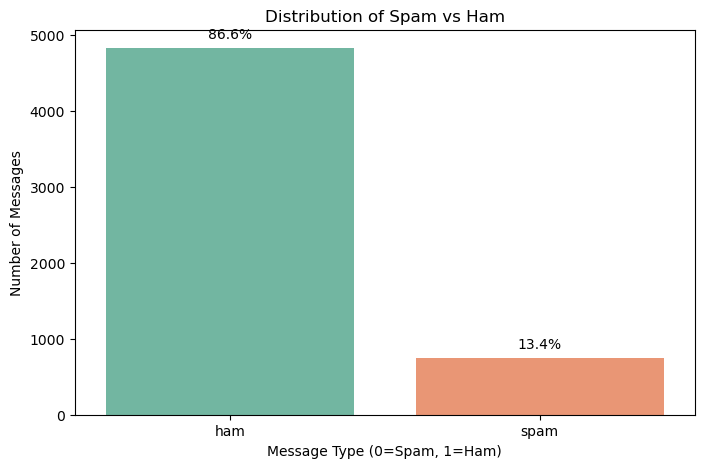

In [19]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='label', data=df, palette='Set2')
plt.title('Distribution of Spam vs Ham')
plt.xlabel('Message Type (0=Spam, 1=Ham)')
plt.ylabel('Number of Messages')

# Add percentage labels on top of bars
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

In [21]:
data['label'] = data['label'].replace({'ham': 1, 'spam': 0}) #----We are replacing the label data with 1 as Ham and 0 as Spam

/var/folders/qh/h1bgsbyx7tnd_5h4rs71xvkm0000gn/T/ipykernel_54217/957923684.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['label'] = data['label'].replace({'ham': 1, 'spam': 0}) #----We are replacing the label data with 1 as Ham and 0 as Spam


In [22]:
data.head()

,label,message
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."


In [23]:
import re

In [24]:
# re (regular expressions) handles all the extra characters like @, #, $ and such signs and symbols.

In [25]:
def data_preprocessing(message):
    # lowercasing all the messages.
    message = message.lower()
    # removing anything that is not a lower cased alphabet with blank space.
    message = re.sub(r'[^a-z]', ' ', message)
    # creating boundary between words while removing the double white spaces if there are any.
    message = " ".join(message.split())
    return message


In [26]:
data['processed_message'] = data['message'].apply(data_preprocessing)


In [28]:
data[['message', 'processed_message']].head()

,message,processed_message
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...


In [30]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prashantrijal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [33]:
def data_preprocessing_1(message):
    word = message.split()
    refined_words = [stemmer.stem(w) for w in word if w not in stop_words]
    return " ".join(refined_words)

In [38]:
data['final_processed_message'] = data['processed_message'].apply(data_preprocessing_1)

In [40]:
data.head()

,label,message,processed_message,final_processed_message
0,1,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,go jurong point crazi avail bugi n great world...
1,1,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joke wif u oni
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...,free entri wkli comp win fa cup final tkt st m...
3,1,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say earli hor u c alreadi say
4,1,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...,nah think goe usf live around though


### Tokenization

In [52]:
from nltk.tokenize import word_tokenize

# Downloading necessary resources
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/prashantrijal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [53]:
def tokenize_message(message):
    # This function takes the cleaned string and breaks it into a list of words
    return word_tokenize(message)

In [54]:
data['tokens'] = data['final_processed_message'].apply(tokenize_message)

In [55]:
# Review the result
print(data[['final_processed_message', 'tokens']].head())

                             final_processed_message  \
0  go jurong point crazi avail bugi n great world...   
1                              ok lar joke wif u oni   
2  free entri wkli comp win fa cup final tkt st m...   
3                u dun say earli hor u c alreadi say   
4               nah think goe usf live around though   

                                              tokens  
0  [go, jurong, point, crazi, avail, bugi, n, gre...  
1                       [ok, lar, joke, wif, u, oni]  
2  [free, entri, wkli, comp, win, fa, cup, final,...  
3      [u, dun, say, earli, hor, u, c, alreadi, say]  
4       [nah, think, goe, usf, live, around, though]  


In [56]:
data.head()

,label,message,processed_message,final_processed_message,tokens
0,1,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,go jurong point crazi avail bugi n great world...,"[go, jurong, point, crazi, avail, bugi, n, gre..."
1,1,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joke wif u oni,"[ok, lar, joke, wif, u, oni]"
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...,free entri wkli comp win fa cup final tkt st m...,"[free, entri, wkli, comp, win, fa, cup, final,..."
3,1,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say earli hor u c alreadi say,"[u, dun, say, earli, hor, u, c, alreadi, say]"
4,1,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...,nah think goe usf live around though,"[nah, think, goe, usf, live, around, though]"


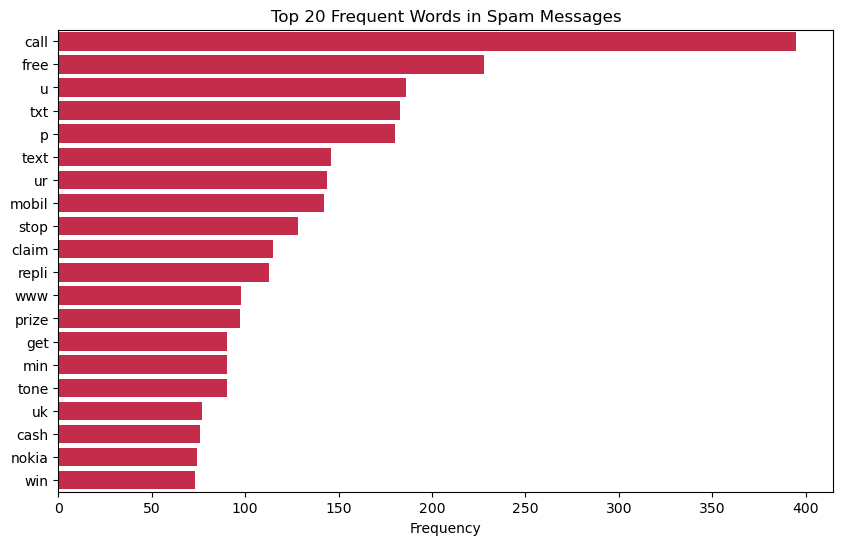

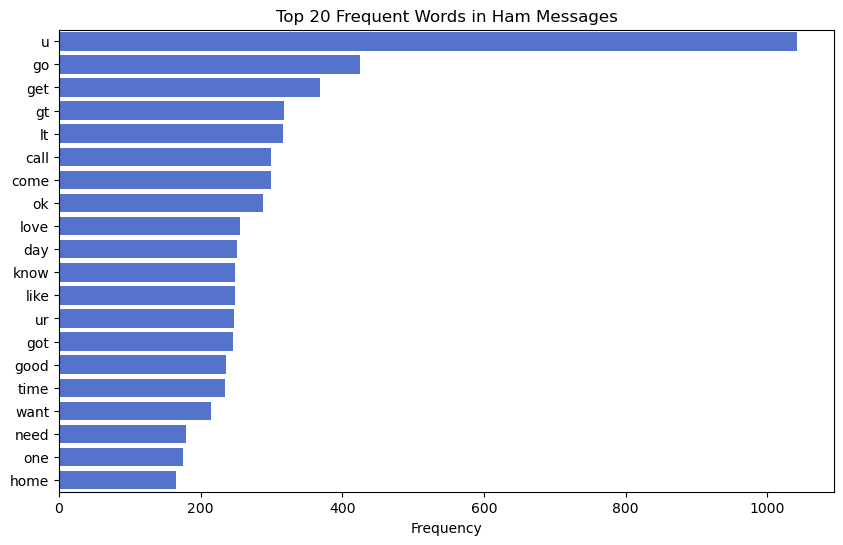

In [57]:
from collections import Counter

def plot_top_words(label_value, title, color):
    # Flatten the list of tokens for the specific label
    all_words = [word for tokens in data[data['label'] == label_value]['tokens'] for word in tokens]
    word_freq = Counter(all_words).most_common(20)
    
    words, counts = zip(*word_freq)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), color=color)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.show()

# Top 20 words in Spam
plot_top_words(0, 'Top 20 Frequent Words in Spam Messages', 'crimson')

# Top 20 words in Ham
plot_top_words(1, 'Top 20 Frequent Words in Ham Messages', 'royalblue')

### Vectorization

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [60]:
tfidf = TfidfVectorizer(max_features=3000)
# We limit to 3000 features to keep the model efficient and remove rare noise

In [61]:
X = tfidf.fit_transform(data['final_processed_message']).toarray()
# Transform the text into a numerical matrix (X)
# We use the final cleaned column

In [62]:
y = data['label'].values
# Extract the target labels (y)
# Assuming your label column is named 'label'

### Train Test Split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the data into Training and Testing sets (80% Train, 20% Test)

In [68]:
print(f"Feature matrix shape: {X.shape}")
print("Vectorization and Split Complete.")

Feature matrix shape: (5572, 3000)
Vectorization and Split Complete.


### Multinomial Naive Bayes

In [73]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

In [75]:
nb_model = MultinomialNB(alpha=1.0)
# Configured with Laplace smoothing (alpha=1.0) for the starting
nb_model.fit(X_train, y_train)

MultinomialNB()

In [77]:
nb_pred = nb_model.predict(X_test)

In [81]:
accuracy_score(y_test, nb_pred)

0.9811659192825112

In [82]:
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.92       149
           1       0.98      1.00      0.99       966

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



### Logistic Regression

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

In [94]:
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [96]:
lr_pred = lr_model.predict(X_test)

In [98]:
accuracy_score(y_test, lr_pred)

0.9713004484304932

In [101]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88       149
           1       0.97      1.00      0.98       966

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



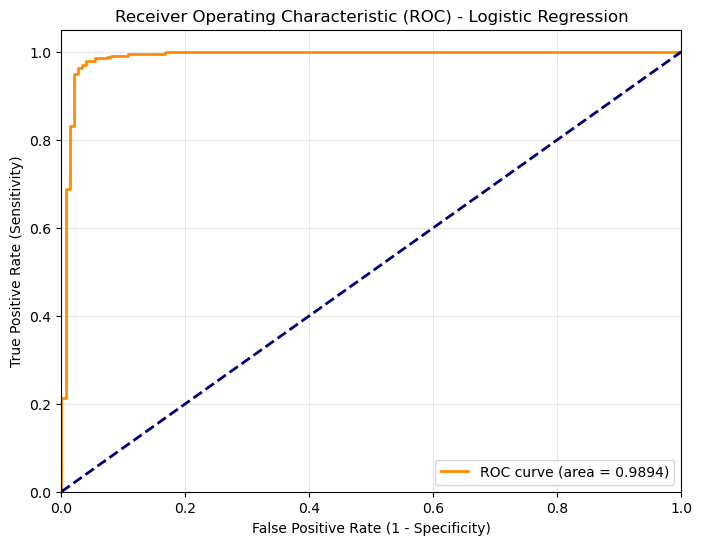

In [103]:
# Getting the predicted probabilities for the Ham
# predict_proba returns [prob_of_0, prob_of_1]
lr_probs = lr_model.predict_proba(X_test)[:, 1]

#Calculating the False Positive Rate, True Positive Rate, and Thresholds
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)

# Calculate for the Area Under the Curve
roc_auc = auc(fpr, tpr)

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonal random line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Support Vector Machine (SVM)

In [108]:
from sklearn.svm import LinearSVC

In [110]:
svm_model = LinearSVC(C=1.0)  # Linear SVM for text classification
svm_model.fit(X_train, y_train)

LinearSVC()

In [112]:
svm_pred = svm_model.predict(X_test)

In [114]:
accuracy_score(y_test, svm_pred)

0.9838565022421525

In [117]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       149
           1       0.98      1.00      0.99       966

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

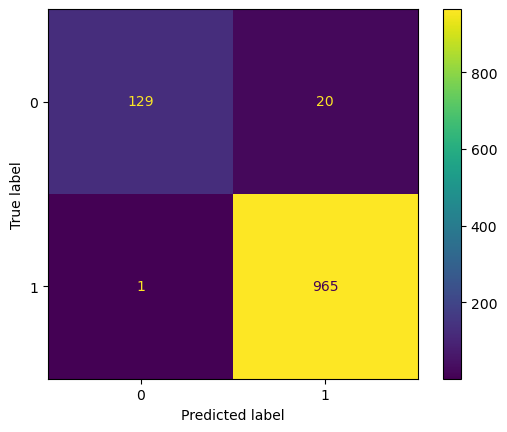

In [123]:
cm = confusion_matrix(y_test, nb_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

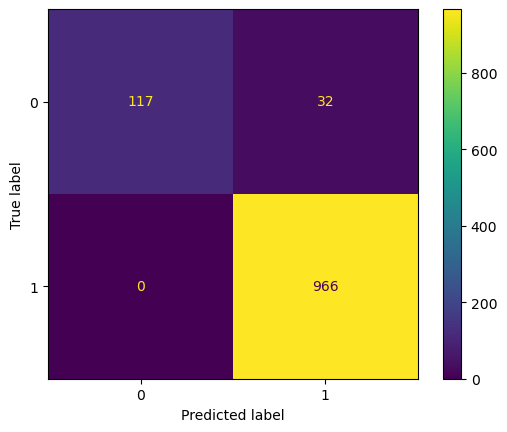

In [125]:
cm = confusion_matrix(y_test, lr_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

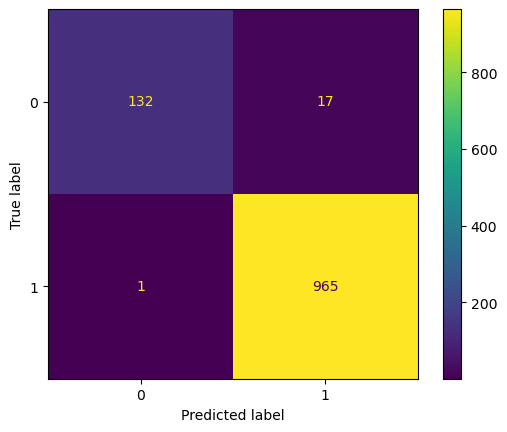

In [127]:
cm = confusion_matrix(y_test, svm_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

### Esemble Learning

In [131]:
from sklearn.ensemble import VotingClassifier

In [132]:
nb = MultinomialNB(alpha=1.0)
lr = LogisticRegression(solver='liblinear')
svm = LinearSVC()

In [135]:
ensemble_model = VotingClassifier(estimators=[('nb', nb),('lr', lr),('svm', svm)],voting='hard')

In [137]:
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('nb', MultinomialNB()),
                             ('lr', LogisticRegression(solver='liblinear')),
                             ('svm', LinearSVC())])

In [138]:
ensemble_pred = ensemble_model.predict(X_test)

print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_pred))
print("\nClassification Report:\n", classification_report(y_test, ensemble_pred))
models = {
    "Naive Bayes": nb_pred,
    "Logistic Regression": lr_pred,
    "SVM": svm_pred,
    "Ensemble": ensemble_pred
}

for name, pred in models.items():
    print(f"{name} Accuracy:", accuracy_score(y_test, pred))

Ensemble Accuracy: 0.979372197309417

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92       149
           1       0.98      1.00      0.99       966

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Naive Bayes Accuracy: 0.9811659192825112
Logistic Regression Accuracy: 0.9713004484304932
SVM Accuracy: 0.9838565022421525
Ensemble Accuracy: 0.979372197309417


In [141]:
from sklearn.metrics import f1_score, precision_score, recall_score

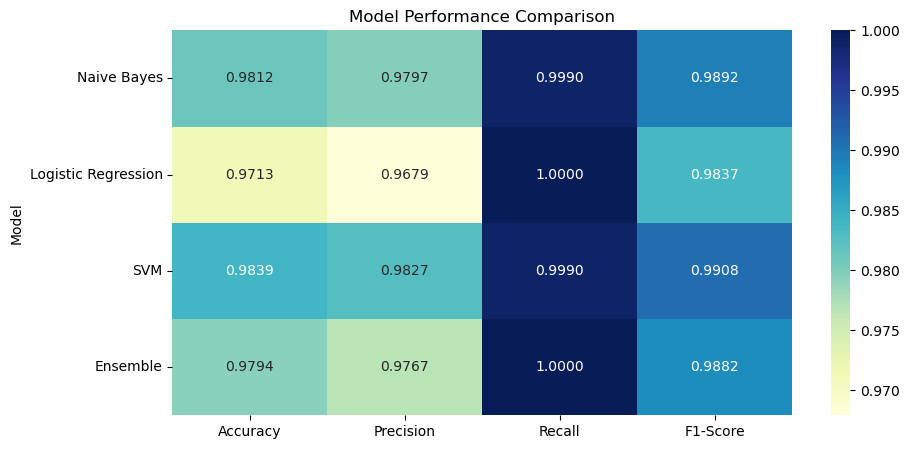

In [144]:
model_list = {
    "Naive Bayes": nb_pred,
    "Logistic Regression": lr_pred,
    "SVM": svm_pred,
    "Ensemble": ensemble_pred
}

performance = []
for name, pred in model_list.items():
    performance.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1-Score": f1_score(y_test, pred)
    })

perf_df = pd.DataFrame(performance).set_index("Model")

# Visualization
plt.figure(figsize=(10, 5))
sns.heatmap(perf_df, annot=True, cmap='YlGnBu', fmt='.4f')
plt.title('Model Performance Comparison')
plt.show()

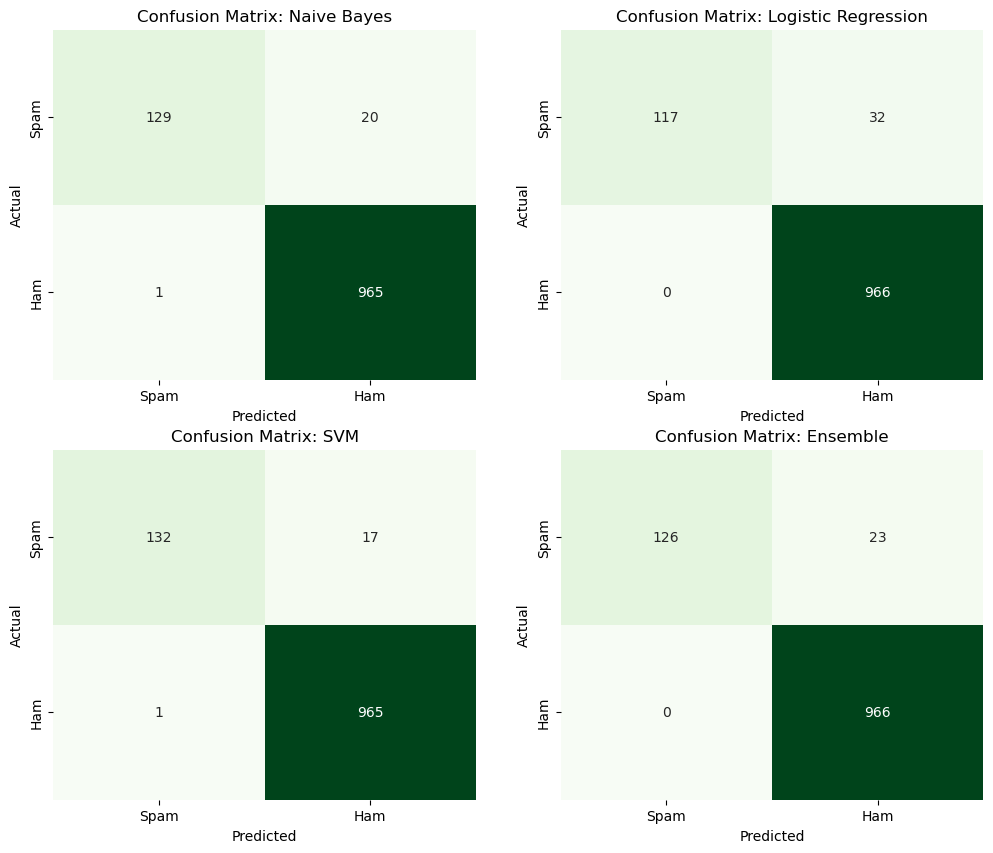

In [160]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
model_names = ["Naive Bayes", "Logistic Regression", "SVM", "Ensemble"]
preds = [nb_pred, lr_pred, svm_pred, ensemble_pred]

for i, ax in enumerate(axes.flatten()):
    cm = confusion_matrix(y_test, preds[i])
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Greens', cbar=False)
    ax.set_title(f'Confusion Matrix: {model_names[i]}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['Spam', 'Ham'])
    ax.set_yticklabels(['Spam', 'Ham'])


In [164]:
def test_new_message(message):
    # 1. Apply the pre-processing functions defined earlier
    # Lowercase + Regex
    cleaned = data_preprocessing(message) 
    # Stopwords + Stemming
    refined = data_preprocessing_1(cleaned)
    
    # 2. Vectorize using the EXISTING tfidf object
    # Use .transform(), NOT .fit_transform()
    vector_input = tfidf.transform([refined]).toarray()
    
    # 3. Get Predictions
    results = {
        "Naive Bayes": nb_model.predict(vector_input)[0],
        "Logistic Regression": lr_model.predict(vector_input)[0],
        "SVM": svm_model.predict(vector_input)[0],
        "Ensemble": ensemble_model.predict(vector_input)[0]
    }
    
    # Format Output
    print(f"Original Message: {message}")
    print("-" * 30)
    for model, pred in results.items():
        label = "HAM " if pred == 1 else "SPAM"
        print(f"{model:20} : {label}")

In [166]:
test_new_message("WINNER!! You have won a 1000 dollar prize. Call 09061701461 to claim your gift now!")

Original Message: WINNER!! You have won a 1000 dollar prize. Call 09061701461 to claim your gift now!
------------------------------
Naive Bayes          : SPAM
Logistic Regression  : SPAM
SVM                  : SPAM
Ensemble             : SPAM


In [168]:
test_new_message("URGENT: Your bank account has a security alert. Please verify your details at bit.ly/fraud-check")

Original Message: URGENT: Your bank account has a security alert. Please verify your details at bit.ly/fraud-check
------------------------------
Naive Bayes          : HAM 
Logistic Regression  : HAM 
SVM                  : HAM 
Ensemble             : HAM 
